** Import **

In [1]:
import kplr
import numpy as np
import matplotlib.pyplot as plt
from exoparams import PlanetParams
import batman
from lmfit import minimize, Parameters, Model
from tqdm import tqdm_notebook
plt.ion()
%matplotlib inline

** Kepler Data Load **

In [2]:
client = kplr.API()
koi3 = client.koi(3.01)

In [3]:
lc3 = koi3.get_light_curves(short_cadence=True)

** Planet Parameters **

In [4]:
keplaunch = 2454833.0
# Data below from Huber et al. 2017
kep3period = 4.88782433
kep3t0 = 2454957.812464 - keplaunch
kep3aoR = 14.64
kep3RpRs = 0.05856
kep3inc = 88.99
kep3ecc = 0.26493
kep3omeg = -162.149
kep3u1 = 0.646
kep3u2 = 0.048

In [12]:
while kep3t0 > keplaunch:
    kep3t0 -= kep3period

** Arrays for Graphing Short Cadence Without NaNs **

In [67]:
times, fluxs, ferrs = [], [], []
for lc in lc3:
    with lc.open() as f:
        hdu_data = f[1].data
        
        baddata   = hdu_data['sap_quality'] != 0
        baddata  &= np.isnan(hdu_data["time"])
        baddata  &= np.isnan(hdu_data["pdcsap_flux"])
        baddata  &= np.isnan(hdu_data["pdcsap_flux_err"])
        
        baddata  &= ~np.isfinite(hdu_data["time"])
        baddata  &= ~np.isfinite(hdu_data["pdcsap_flux"])
        baddata  &= ~np.isfinite(hdu_data["pdcsap_flux_err"])
        baddata   = np.where(baddata)
        
        if f[0].header['OBSMODE'] == 'short cadence':
            times.append(np.delete(hdu_data["time"]           , baddata, None))
            fluxs.append(np.delete(hdu_data["pdcsap_flux"]    , baddata, None))
            ferrs.append(np.delete(hdu_data["pdcsap_flux_err"], baddata, None))

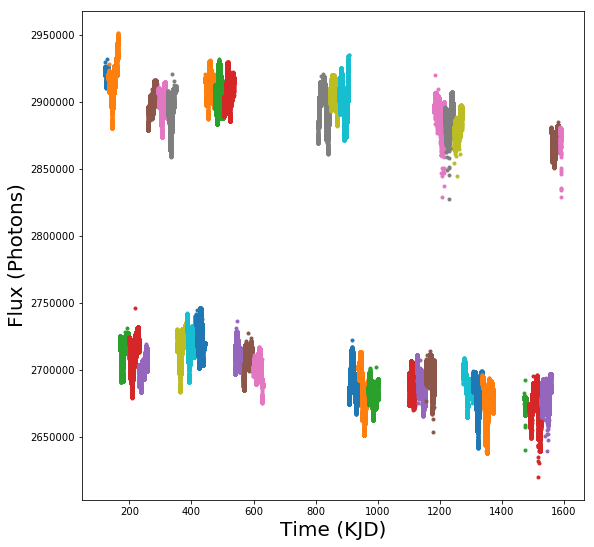

In [68]:
plt.figure(figsize=(9, 9))
for i in range(len(times)):
    plt.errorbar(times[i], fluxs[i], yerr = ferrs[i], fmt = '.')

plt.xlabel("Time (KJD)", fontsize = 20)
plt.ylabel("Flux (Photons)", fontsize = 20)

** Spliting and Phasing Transits **

KeyboardInterrupt: 

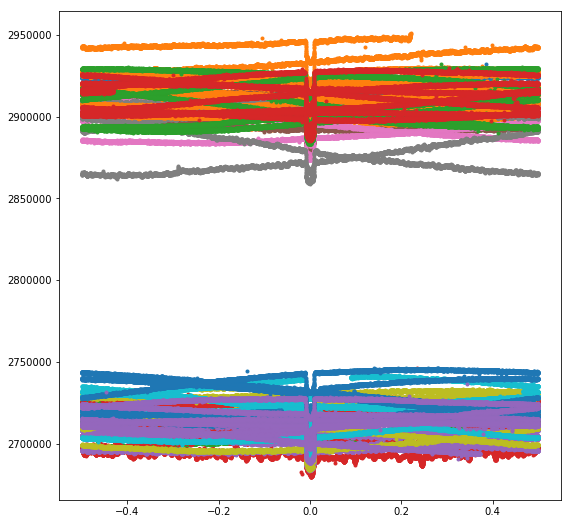

In [69]:
plt.figure(figsize=(9,9))
for pl in range(len(times)):
    phasei = ((times[pl] - kep3t0) % kep3period)/kep3period
    phasei[phasei > .5] -= 1
    plt.errorbar(phasei, fluxs[pl], yerr = ferrs[pl], fmt = '.')

In [ ]:
epochsNums = []
for pl in tqdm_notebook(range(len(times)), total = len(times)):
    for k in range(int(max(times[pl]) / kep3period)):
        if (kep3t0 + k*kep3period) >= min(times[pl]) and (kep3t0 + k*kep3period) <= max(times[pl]):
            epochsNums.append(k)

**Slice Epochs Into Arrays**

In [ ]:
sliceWidth = 0.5
timeSlices , fluxSlices, ferrSlices, epochs = [], [], [], []
for pl in tqdm_notebook(range(len(times)), total = len(times)):
    for k in epochsNums:
        tranCenter    = kep3t0 + k * kep3period
        if tranCenter >= min(times[pl]) and tranCenter <= max(times[pl]):
            transitSlices = abs(times[pl] - tranCenter) < sliceWidth
            if len(transitSlices) > 0 and len(times[pl][transitSlices]) > 0:
                timeSlices.append(times[pl][transitSlices])
                fluxSlices.append(fluxs[pl][transitSlices])
                ferrSlices.append(ferrs[pl][transitSlices])
                epochs.append(tranCenter)

In [ ]:
plt.figure(figsize=(9,9))
for eachEpoch in range(len(timeSlices)):
    plt.errorbar(timeSlices[eachEpoch] ,fluxSlices[eachEpoch], ferrSlices[eachEpoch], fmt = '.' )

In [ ]:
plt.figure(figsize = (9,9))
for timeNow, fluxNow, ferrNow, kep3epochNow in zip(timeSlices, fluxSlices, ferrSlices, epochs):
    plt.errorbar(timeNow - kep3epochNow, fluxNow / np.median(fluxNow) \
                 , ferrNow / np.median(fluxNow), fmt='.')

**Outliers**

In [ ]:
plt.figure(figsize = (9,9))
nsigma = 5
for itran in range(len(epochs)):
    fluxdiff = np.diff(fluxSlices[itran])
    plt.plot(fluxdiff)
    plt.axhline(np.nanmedian(fluxdiff) + nsigma * np.nanstd(fluxdiff), \
                color = 'k', linestyle = '-', linewidth = 1)
    plt.axhline(np.nanmedian(fluxdiff) - nsigma * np.nanstd(fluxdiff), \
                color = 'k', linestyle = '-', linewidth = 1)

In [64]:
fluxSlicesTemp = fluxSlices.copy()

nsigma = 5
for itran in range(len(epochs)):
    fluxdiff = np.diff(fluxSlicesTemp[itran])
    outliers = np.where(abs(fluxdiff - np.nanmedian(fluxdiff)) > nsigma * np.nanstd(fluxdiff))[0]
    for o in outliers:
        beforeOutlier = list(fluxSlicesTemp[itran][o - 10: o + 0])
        afterOutlier  = list(fluxSlicesTemp[itran][o + 1: o + 11])
        fluxSlicesTemp[itran][o] = np.median(beforeOutlier + afterOutlier) #+ fluxdiff[o]
    fluxdiff = np.diff(fluxSlicesTemp[itran])
    print(itran, np.where(abs(fluxdiff - np.nanmedian(fluxdiff)) > nsigma * np.nanstd(fluxdiff))[0]) 

/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/jonathan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


0 [800]
1 []
2 []
3 []
4 []
5 [325]
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 [1461 1462]
15 []
16 [ 661 1127]
17 []
18 [805 806 810 811]
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 [763]
47 []
48 []
49 []
50 []
51 []
52 []
53 [1402]
54 []
55 [102]
56 []
57 []
58 [972 973]
59 []
60 []
61 []
62 []
63 [893]
64 [ 690  841  854  855  901 1168 1289]
65 []
66 [57]
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 [610]
75 []
76 [616]
77 []
78 []
79 [797]
80 []
81 []
82 []
83 []
84 []
85 []
86 [798]
87 [47 48]
88 []
89 []
90 []
91 []
92 []
93 []
94 [1461]
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 [796 799]
104 [804]
105 []
106 []
107 []
108 [756]
109 []
110 []
111 [127]
112 [799]
113 []
114 [754]
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 [102]
123 []
124 []
125 []
126 [ 758  795 1466]
127 []
128 []
129 []
130 [ 38  39  45  46  81  82 408]
131 [440 44

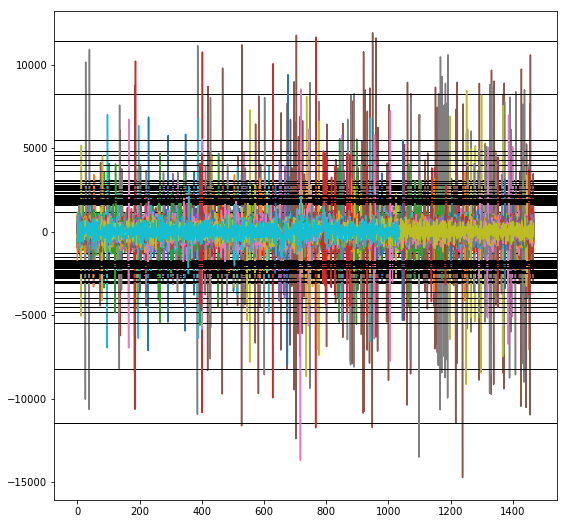

In [65]:
plt.figure(figsize = (9,9))
nsigma = 5
for itran in range(len(epochs)):
    fluxdiff = np.diff(fluxSlicesTemp[itran])
    plt.plot(fluxdiff)
    plt.axhline(np.nanmedian(fluxdiff) + nsigma * np.nanstd(fluxdiff), \
                color = 'k', linestyle = '-', linewidth = 1)
    plt.axhline(np.nanmedian(fluxdiff) - nsigma * np.nanstd(fluxdiff), \
                color = 'k', linestyle = '-', linewidth = 1)

In [31]:
for itran in range(len(epochs)):
    ferrNans = np.where(np.isnan(ferrSlices[itran]))
    for n in ferrNans:
        ferrNan = np.nanmedian(ferrSlices[itran])
        ferrSlices[itran][n] = ferrNan
    
    print(itran, np.where(np.isnan(ferrSlices[itran])))

0 (array([], dtype=int64),)
1 (array([], dtype=int64),)
2 (array([], dtype=int64),)
3 (array([], dtype=int64),)
4 (array([], dtype=int64),)
5 (array([], dtype=int64),)
6 (array([], dtype=int64),)
7 (array([], dtype=int64),)
8 (array([], dtype=int64),)
9 (array([], dtype=int64),)
10 (array([], dtype=int64),)
11 (array([], dtype=int64),)
12 (array([], dtype=int64),)
13 (array([], dtype=int64),)
14 (array([], dtype=int64),)
15 (array([], dtype=int64),)
16 (array([], dtype=int64),)
17 (array([], dtype=int64),)
18 (array([], dtype=int64),)
19 (array([], dtype=int64),)
20 (array([], dtype=int64),)
21 (array([], dtype=int64),)
22 (array([], dtype=int64),)
23 (array([], dtype=int64),)
24 (array([], dtype=int64),)
25 (array([], dtype=int64),)
26 (array([], dtype=int64),)
27 (array([], dtype=int64),)
28 (array([], dtype=int64),)
29 (array([], dtype=int64),)
30 (array([], dtype=int64),)
31 (array([], dtype=int64),)
32 (array([], dtype=int64),)
33 (array([], dtype=int64),)
34 (array([], dtype=int6

** Fitting the transit with BATMAN **

In [16]:
timeSlicesMod = []
for itran in range(len(epochs)):
    timeSlicesMod += [np.linspace(np.nanmin(timeSlices[itran]), np.nanmax(timeSlices[itran]), \
                                  len(timeSlices[itran]))]

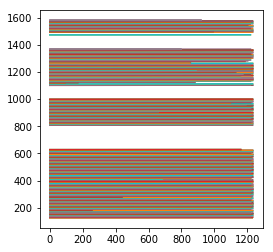

In [17]:
plt.figure(figsize=(4,4))
for itran in range(len(epochs)):
    plt.plot(timeSlices[itran])
    plt.plot(timeSlicesMod[itran], '-')

In [18]:
tparams = batman.TransitParams()
tparams.t0 = kep3t0                     #time of inferior conjunction
tparams.per = kep3period                #orbital period 
tparams.rp = kep3RpRs                   #planet radius (in units of stellar radii)
tparams.a = kep3aoR                     #semi-major axis (in units of stellar radii)
tparams.inc = kep3inc                   #orbital inclination (in degrees)
tparams.ecc = kep3ecc                   #eccentricity
tparams.w = kep3omeg                    #longitude of periastron (in degrees)
tparams.limb_dark = "quadratic"         #limb darkening model
tparams.u = [kep3u1, kep3u2]            #limb darkening coefficients [u1, u2, u3, u4]

sliceLcModel = []
for itran in range(len(epochs)):
    sliceLcModel += [batman.TransitModel(tparams, timeSlicesMod[itran], transittype ='primary')]

In [19]:
lcKepModel = []
for itran in range(len(epochs)):
    lcKepModel += [sliceLcModel[itran].light_curve(tparams)]

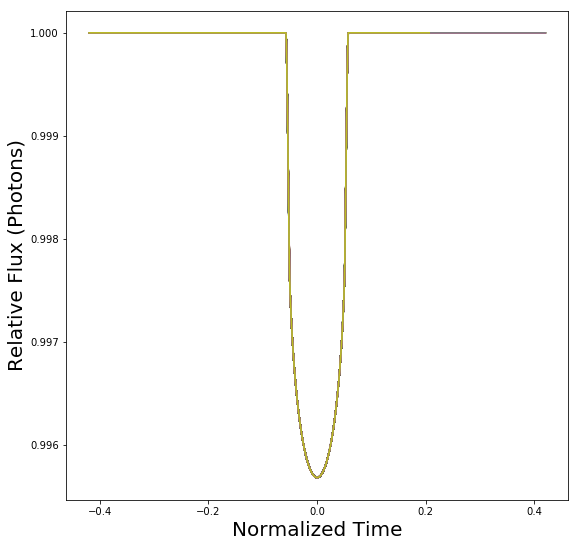

In [20]:
plt.figure(figsize = (9,9))

for timeSlice, epoch, BatModel in zip(timeSlicesMod, epochs, lcKepModel):
    plt.plot(timeSlice - epoch, BatModel)
    plt.xlabel("Normalized Time", fontsize = 20)
    plt.ylabel("Relative Flux (Photons)", fontsize = 20)

** LMFIT Model fitting **

In [21]:
def batman_wrapper_lmfit(period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2, 
                         offset, slope, curvature,
                         times, ldtype='quadratic', transitType='primary'):

    # period, tcenter, inc, aprs, rprs, ecc, omega, u1, u2 = init_params
    
    if offset == 1.0 and slope == 0.0 and curvature == 0.0:
        OoT_curvature = 1.0 # OoT == Out of transit
    else:
        OoT_curvature = offset + slope*(times-times.mean()) + curvature*(times-times.mean())**2
    
    bm_params           = batman.TransitParams() # object to store transit parameters

    bm_params.per       = period   # orbital period
    bm_params.t0        = tcenter  # time of inferior conjunction
    bm_params.inc       = inc      # inclunaition in degrees
    bm_params.a         = aprs     # semi-major axis (in units of stellar radii)
    bm_params.rp        = rprs     # planet radius (in units of stellar radii)
    bm_params.ecc       = ecc      # eccentricity
    bm_params.w         = omega    # longitude of periastron (in degrees)
    bm_params.limb_dark = ldtype   # limb darkening model # NEED TO FIX THIS
    bm_params.u         = [u1, u2] # limb darkening coefficients # NEED TO FIX THIS

    m_eclipse = batman.TransitModel(bm_params, times, transittype=transitType)# initializes model

    return m_eclipse.light_curve(bm_params) * OoT_curvature

In [22]:
initialParams = Parameters()

initialParams.add_many(
    ('period' , kep3period, False),
    ('tcenter' , kep3t0, True, kep3t0 - 0.1, kep3t0 + 0.1),
    ('inc' , kep3inc, True, 80., 90.),
    ('aprs' , kep3aoR, True, 10, 20),
    ('rprs' , kep3RpRs, True, 0.01, 0.1),
    ('ecc' , kep3ecc, False),
    ('omega' , kep3omeg, False),
    ('u1' , kep3u1, True, 0.6, 0.7),
    ('u2' , kep3u2, True, 0.0, 0.1),
    ('offset', 1.0, True, 0.0),
    ('slope', 0.0, True),
    ('curvature', 0.0, True))

In [23]:
initialParams

Parameters([('period',
             <Parameter 'period', value=4.88782433 (fixed), bounds=[-inf:inf]>),
            ('tcenter',
             <Parameter 'tcenter', 124.81246400019154, bounds=[124.71246400019155:124.91246400019153]>),
            ('inc', <Parameter 'inc', 88.99, bounds=[80.0:90.0]>),
            ('aprs', <Parameter 'aprs', 14.64, bounds=[10:20]>),
            ('rprs', <Parameter 'rprs', 0.05856, bounds=[0.01:0.1]>),
            ('ecc',
             <Parameter 'ecc', value=0.26493 (fixed), bounds=[-inf:inf]>),
            ('omega',
             <Parameter 'omega', value=-162.149 (fixed), bounds=[-inf:inf]>),
            ('u1', <Parameter 'u1', 0.646, bounds=[0.6:0.7]>),
            ('u2', <Parameter 'u2', 0.048, bounds=[0.0:0.1]>),
            ('offset', <Parameter 'offset', 1.0, bounds=[0.0:inf]>),
            ('slope', <Parameter 'slope', 0.0, bounds=[-inf:inf]>),
            ('curvature', <Parameter 'curvature', 0.0, bounds=[-inf:inf]>)])

In [24]:
lc = Model(batman_wrapper_lmfit, 
              independent_vars = ['times', 'ldtype', 'transitType'])

In [25]:
fitResult = []
for itran in tqdm_notebook(range(len(epochs)), total = len(epochs), desc = 'fitResult'):
    fitResult += [lc.fit(fluxSlices[itran],
                   weights     = 1 / ferrSlices[itran] ** 2.,
                   params      = initialParams,
                   method      = 'powell',
                   times       = timeSlicesMod[itran],
                   ldtype      = 'quadratic',
                   transitType = 'primary')]

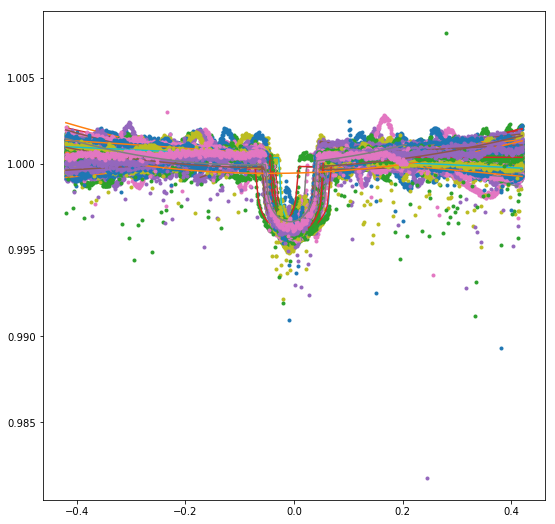

In [26]:
plt.figure(figsize=(9,9))
for timeSlice, epoch, lmModel, fluxSlice in zip(timeSlicesMod, epochs, fitResult, fluxSlices):
    plt.plot(timeSlice - epoch, fluxSlice / fluxSlice.mean(),'.')
    plt.plot(timeSlice - epoch, lmModel.best_fit / lmModel.best_fit.mean())

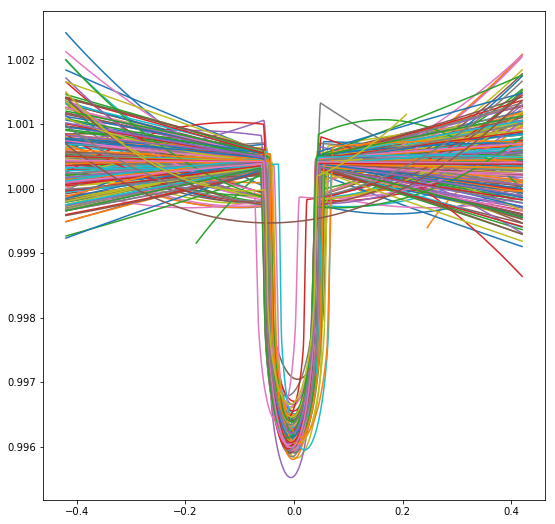

In [27]:
plt.figure(figsize=(9,9))
for timeSlice, epoch, lmModel in zip(timeSlicesMod, epochs, fitResult):
    plt.plot(timeSlice - epoch,lmModel.best_fit / lmModel.best_fit.mean())

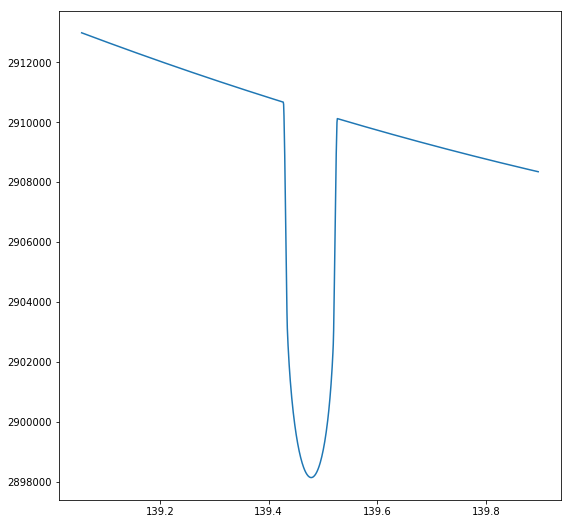

In [29]:
n = 3
plt.figure(figsize=(9,9))
plt.plot(timeSlices[n], fitResult[n].best_fit )